# VAE using Jesture dataset

In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.optimizers import Adam 
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import metrics

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import datetime as dt

Using TensorFlow backend.


### Load Jesture dataset

In [6]:
def load_JESTER(path):
    """
    Imports the JESTER Dataset (12,2,100,176)
    """
    xs_train, ys_train, xs_test, ys_test = [], [], [], []

    classList=['Swiping_Left', 'Swiping_Right', 'Swiping_Up', 'Swiping_Down']
    #classList=['Swiping_Left', 'Swiping_Right', 'Swiping_Up']    
    for class_index in classList:
        for (root, dirs, f) in os.walk('{0}/n_Train/{1}'.format(path, str(class_index))):
            cnt=0
            print('Loading Train set')
            for file in f:
                cnt += 1
                if (cnt == 1001):
                    #print('Percent : {}%'.format(round((cnt / len(f)) * 100, 2)))
                    break
                
                X=np.load('{0}/n_Train/{1}/{2}'.format(path, str(class_index), file))
                xs_train.append(X)
                ys_train.append(class_index)

        for (root, dirs, f) in os.walk('{0}/n_Test/{1}'.format(path, str(class_index))):
            cnt=0
            print('Loading Test set')
            for file in f:
                cnt += 1
                if (cnt == 101):
                    print('Percent : {}%'.format(round((cnt / len(f)) * 100, 2)))
                    break
                        
                X = np.load('{0}/n_Test/{1}/{2}'.format(path, str(class_index), file))
                xs_test.append(X)
                ys_test.append(class_index)

    Xtr = np.array(xs_train)
    Ytr = np.array(ys_train)
    Xte = np.array(xs_test)
    Yte = np.array(ys_test)
    
    return Xtr, Ytr, Xte, Yte

In [7]:
dataset_class_path = 'M:/LowPowerActionRecognition/CNN/JESTER/datasets/n_JESTER'
x_train_1, y_train, x_test_1, y_test = load_JESTER(dataset_class_path)
#x_train_1, y_train = load_JESTER(dataset_class_path)

Loading Train set
Loading Test set
Percent : 20.45%
Loading Train set
Loading Test set
Percent : 20.78%
Loading Train set
Loading Test set
Percent : 19.88%
Loading Train set
Loading Test set
Percent : 19.42%


In [8]:
# As a sanity check, we print out the size of the training and test data.
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

print('Training data shape: ', x_train_1.shape)
print('Training labels shape: ', y_train.shape)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Test data shape: ', x_test_1.shape)
print('Test labels shape: ', y_test.shape)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training data shape:  (4000, 12, 2, 100, 176)
Training labels shape:  (4000,)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test data shape:  (400, 12, 2, 100, 176)
Test labels shape:  (400,)


Current problem, each data sample for Jesture size is 1,651Kb compare to 10Kb for NMNIST dataset, meaning it carries more information and result in memory error when load the jesture dataset.

Due tothe memory error, I only load the x_train data for the first 1500 datasamples in each gesture. Resulting in (6000, 12, 2, 100, 176) ie.=2534400000. In the original data folder, the amount of samples varies in each gesture but average in around 4000+ samples so currently, less than half of the training dataset are chosen to test right now.

The data structure: 
{6000 samples -> 1500 per gesture} divides in {12 frames/chunks} with {2 polarities +/-} and has the coordinate x{range to 100} & y{range to 176} 

Data labels: 'Swiping_Left', 'Swiping_Right', 'Swiping_Up', 'Swiping_Down'

### Preprocessing

(12, 2, 100, 176)


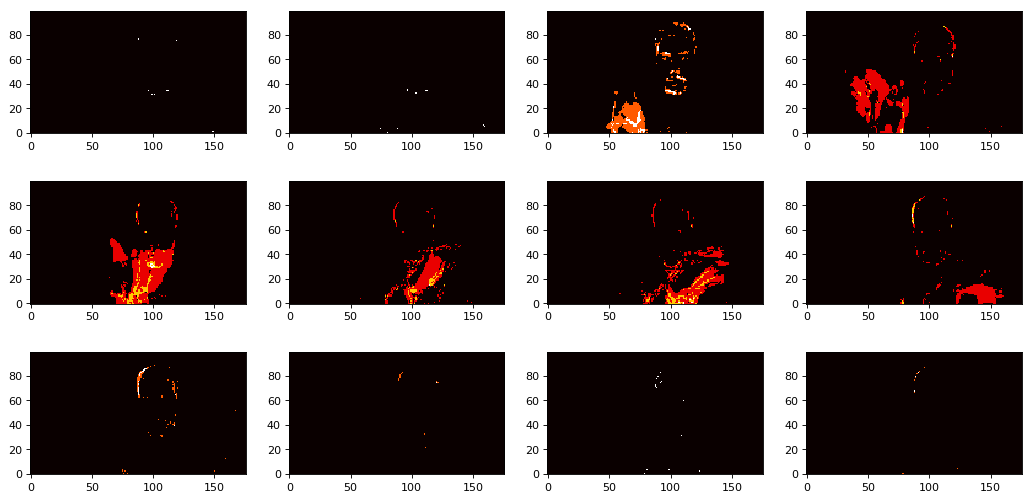

In [9]:
#Visualisation in 12 chunks
path = 'M:/LowPowerActionRecognition/CNN/JESTER/datasets/n_JESTER/n_Train/Swiping_Left/477;Swiping_Left.npy'
A=np.load(path)
print(A.shape)
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(A[i][0], cmap='hot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='hot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1))

In [ ]:
# Test to see the maxima and minima of the dataset to flatten it
x_train_1 = x_train_1.reshape(6000,422400)
print(x_train_1.shape)
maxi = x_train_1[0][0]
mini = x_train_1[0][0]
for i in range (0, len(x_train_1)):
    if (max(x_train_1[i])>maxi):
        maxi = max(x_train_1[i])
    if (min(x_train_1[i])<mini):
        mini = min(x_train_1[i])
print(maxi)
print(mini)

In [9]:
# Test to see the maxima and minima of the dataset to flatten it
x_test_1 = x_test_1.reshape(2008,422400)
print(x_test_1.shape)
maxi = x_test_1[0][0]
mini = x_test_1[0][0]
for i in range (0, len(x_test_1)):
    if (max(x_test_1[i])>maxi):
        maxi = max(x_test_1[i])
    if (min(x_test_1[i])<mini):
        mini = min(x_test_1[i])
print(maxi)
print(mini)

(2008, 422400)
5
0


In [29]:
x_train = x_train_1.reshape(4000,422400)
x_test = x_test_1.reshape(400,422400)
print(x_train.shape)
print(x_test.shape)

(4000, 422400)
(400, 422400)


In [30]:
#Shuffle the dataset in a random manner
idx = np.random.permutation(len(x_train))
x_train, y_train = x_train[idx], y_train[idx]

idx2 = np.random.permutation(len(x_test))
x_test, y_test = x_test[idx2], y_test[idx2]

MemoryError: 

In [31]:
# Flatten the dataset from range -1 to 1. Since the maxima and minima lies btw 15 so we divide it by 15.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

MemoryError: 

In [14]:
#Set the data in range of 15/45 to 43/45 and the zeros are left untouched. Zeros are filled around the matrix
#x_train_1[x_train_1!=0]+= 5
#x_test[x_test!=0]+= 30

x_train[:] = [x/5 for x in x_train]
x_test[:] = [x/5 for x in x_test]

In [ ]:
"""#Test range
maxi = x_train_1[0][0]
mini = x_train_1[0][0]
for i in range (0, len(x_train_1)):
    if (max(x_train_1[i])>maxi):
        maxi = max(x_train_1[i])
    if (min(x_train_1[i])<mini):
        mini = min(x_train_1[i])
print(maxi)
print(mini)"""

In [ ]:
# Due to memory error the data lies between 0-5

In [15]:
def plot_autoencoder_outputs(encoder, n, dims):
    #decoded_imgs = enconder.predict(x_test)
    x_test_encoded = vae.predict(x_test, batch_size = batch_size)
    # number of example digits to show
    n = 5
    plt.figure(figsize=(20, 9))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_test_encoded[i].reshape(*dims))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

In [ ]:
"""x_train[x_train>0]=1
x_train[x_train<0]=-1
x_test[x_test>0]=1
x_test[x_test<0]=-1
#print(x_train.shape)
print(np.max(x_train[0]))"""

In [16]:
epsilon_std = 0.0001

# z = z_mean + sqrt(var)*eps
#returns random value of z with the gives mean and variance
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma/2) * epsilon

In [17]:
# network parameters
#batch_size - number of training examples 
#that are used at the same time to train the NN
#latent_dim - defines the dimentionality of the latent space
#2D latent space in this case
input_shape = (422400, )
intermediate_dim_1 = 512 # 64
intermediate_dim_2 = 256 # 32
intermediate_dim_3 = 128 # 16
intermediate_dim_4 = 64 # 16
intermediate_dim_5 = 32
batch_size = 100
latent_dim = 2
epochs = 10

In [18]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input') #2312
x = Dense(intermediate_dim_1, activation='relu')(inputs)
x = Dense(intermediate_dim_2, activation='relu')(x)
x = Dense(intermediate_dim_3, activation='relu')(x)
x = Dense(intermediate_dim_4, activation='relu')(x)
x = Dense(intermediate_dim_5, activation='tanh')(x)
# x = Dense(intermediate_dim_2, activation='relu')(inputs)
# x = Dense(intermediate_dim_3, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [19]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 422400)       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          216269312   encoder_input[0][0]              
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          131328      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          32896       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [20]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim_5, activation='tanh')(latent_inputs)
x = Dense(intermediate_dim_4, activation='relu')(x)
x = Dense(intermediate_dim_3, activation='relu')(x)
x = Dense(intermediate_dim_2, activation='relu')(x)
x = Dense(intermediate_dim_1, activation='relu')(x)
# x = Dense(intermediate_dim_3, activation='relu')(latent_inputs)
# x = Dense(intermediate_dim_2, activation='relu')(x)
outputs = Dense(422400, activation='sigmoid')(x)

In [21]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_11 (Dense)             (None, 422400)            216691200 
Total para

In [22]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae_test=Model(inputs, outputs, name='vae_test')

In [23]:
# Compute VAE loss
xent_loss = 422400 * binary_crossentropy(inputs, outputs)
#xent_loss = binary_crossentropy(inputs, outputs)

kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss =abs(K.mean(xent_loss + kl_loss))

opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999)

vae.add_loss(vae_loss)
#vae.compile(optimizer='adam')
vae.compile(optimizer=opt, metrics=['accuracy'])

vae_test.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
#vae_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vae.summary()
vae_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 422400)            0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 216444004 
_________________________________________________________________
decoder (Model)              (None, 422400)            216866336 
Total params: 433,310,340
Trainable params: 433,310,340
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 422400)            0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 216444004 
______________________________________________________________

In [24]:
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

The loss function taking into account 2 factors, kl_loss and 

In [40]:
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

# changes to epochs, validation_split and batch_size
history = vae.fit(x_train,    
        shuffle = False, #already shuffle data before hand
        epochs= epochs,
        validation_split= 0.2,
        batch_size= batch_size,
        callbacks = [tensorboard])

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2019-02-07 09:38:54.333633
Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 319s 100ms/step - loss: 90153.2109 - val_loss: 73152.0723
Epoch 2/10
3200/3200 [==============================] - 321s 100ms/step - loss: 72208.3667 - val_loss: 72631.3359
Epoch 3/10
3200/3200 [==============================] - 320s 100ms/step - loss: 72347.9424 - val_loss: 72718.1309
Epoch 4/10
3200/3200 [==============================] - 321s 100ms/step - loss: 72407.2981 - val_loss: 72696.2402
Epoch 5/10
3200/3200 [==============================] - 316s 99ms/step - loss: 72499.6523 - val_loss: 72721.0205
Epoch 6/10
3200/3200 [==============================] - 321s 100ms/step - loss: 72357.6470 - val_loss: 72686.9492
Epoch 7/10
3200/3200 [==============================] - 315s 99ms/step - loss: 72271.6731 - val_loss: 72639.2451
Epoch 8/10
3200/3200 [==============================] - 318s 99ms/step - loss: 72260.7422 - val_loss: 72606.8428

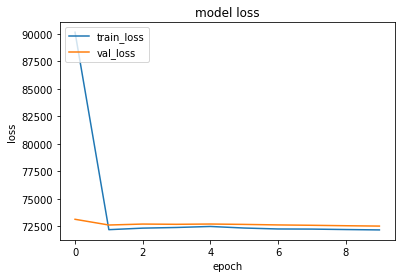

In [41]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [33]:
"""x_train = x_train_1[0:5000]
x_val = x_train_1[5000:6000]
print(x_train.shape)
print(x_val.shape)"""
print(x_train.shape)

(4000, 422400)


In [39]:
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

# changes to epochs, validation_split and batch_size
history = vae.fit_generator(
        (x_train,_),    
        shuffle = False, #already shuffle data before hand
        epochs= epochs,
        validation_data = (x_test,_),
        #validation_split= 0.2,
        steps_per_epoch =len(x_train) // batch_size,                    
        #batch_size= batch_size,
        callbacks = [tensorboard])

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2019-02-07 09:38:20.470201
Epoch 1/10


TypeError: 'tuple' object is not an iterator

dict_keys(['val_loss', 'loss'])


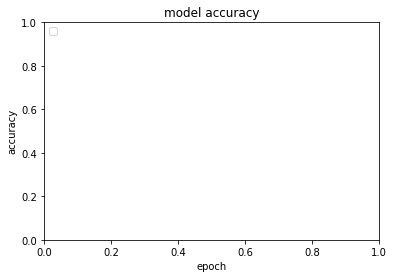

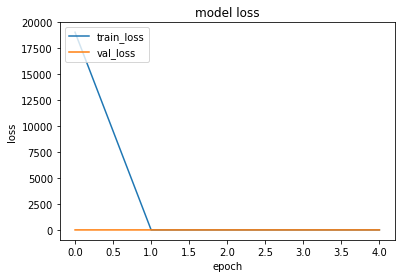

In [34]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [42]:
models = (encoder, decoder)
data = (x_test, y_test)

In [46]:
z_mean, z_var, _ = encoder.predict(x_test, batch_size=batch_size)
print(z_mean.shape)
print(z_var.shape)


(400, 2)
(400, 2)


In [49]:
store_this = []
store_this.append(z_mean)
store_this.append(z_var)
store_this2 = np.array(store_this)
print(store_this2.shape)
np.save('OUTPUT_ENCODER.npy',store_this2)
# size is 6.3kB for the current data for test

(2, 400, 2)


In [44]:
def plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    print(z_mean)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    #plt.savefig('foo.png')    
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

[[ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]
 [ 1.844716  -3.7608142]


ValueError: c of shape (400,) not acceptable as a color sequence for x with size 400, y with size 400

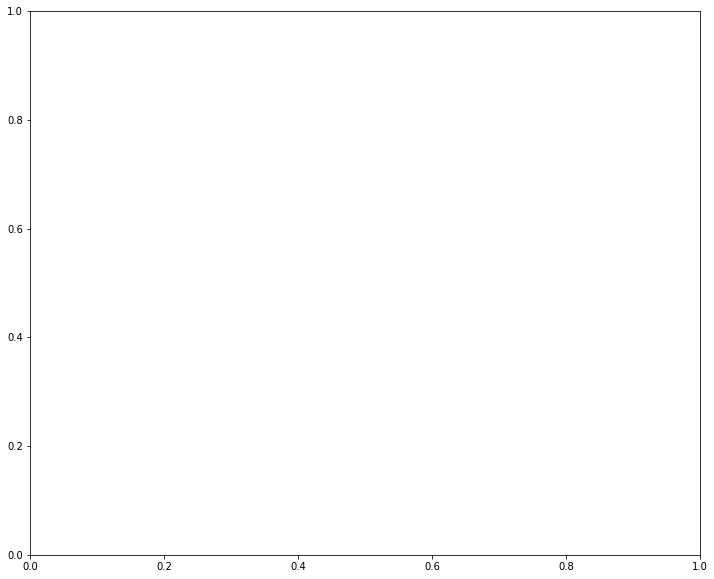

In [45]:
a =plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")


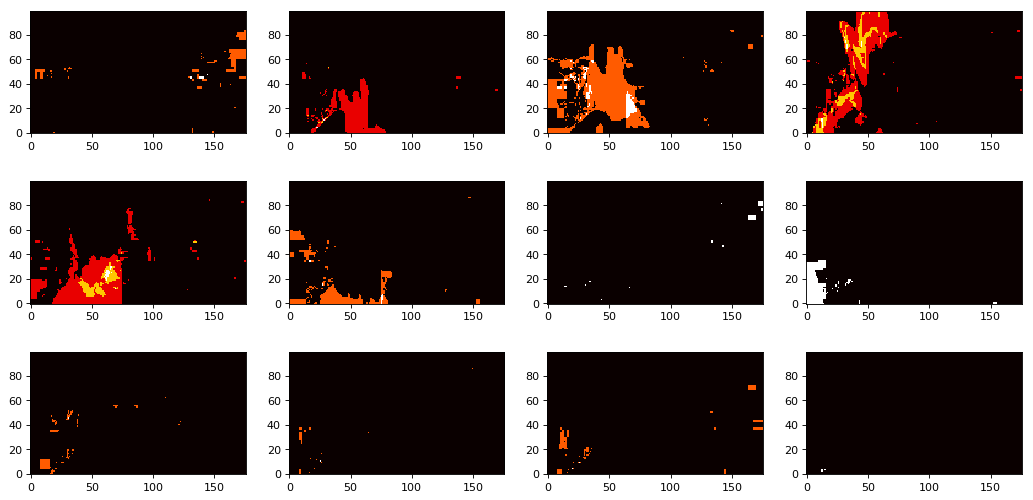

In [59]:
#Visualisation in 12 chunks
A= x_test[100].reshape(12, 2, 100, 176)
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(A[i][0], cmap='hot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='hot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1))

In [52]:
x_test_encoded = vae_test.predict(x_test, batch_size = batch_size)

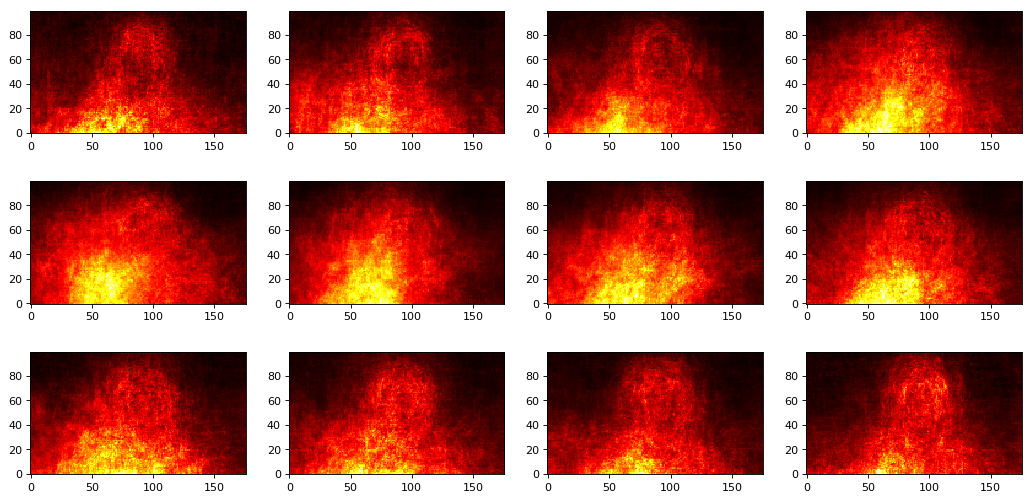

In [62]:
#Visualisation in 12 chunks
A= x_test_encoded[23].reshape(12, 2, 100, 176)
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(A[i][0], cmap='hot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='hot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1))

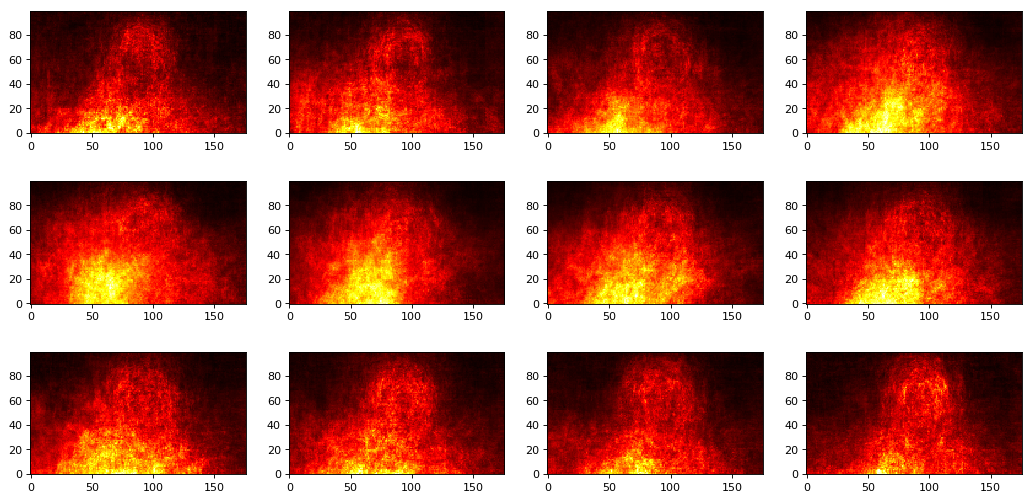

In [66]:
#Visualisation in 12 chunks
A= x_test_encoded[39].reshape(12, 2, 100, 176)
fig=plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
for cnt,i in enumerate(range(12)):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(A[i][0], cmap='hot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format(cnt*2))
    plt.imshow(A[i][1], cmap='hot', interpolation='nearest')
    plt.gca().invert_yaxis()
    #plt.savefig("mytable{}.png".format((cnt*2)+1))

In [ ]:
import pandas as pd
plot_loss(history)

In [ ]:
n = 15
plt.figure(figsize=(20, 2))
j=9000
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[j].reshape(34, 68))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_encoded[j].reshape(34, 68))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
    j = j+1

In [ ]:
#plot_autoencoder_outputs(x_test, 5, (34, 68))

In [61]:
vae_test.set_weights(vae.get_weights())

from random import shuffle

score = vae_test.evaluate(x_test, x_test, verbose=1, batch_size=batch_size)
#score = vae.evaluate(x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

400/400 [==============================] - 9s 23ms/step
Test loss: 0.18161284551024437
Test accuracy: 0.9568560421466827


Saving the data to a local folder so we dont have to run everything again.

In [ ]:
# This is the shuffled data for normal operation SVM:
np.save('x_train_1.npy',x_train_1)
np.save('x_test_1.npy',x_test_1)

#This is the data outputed from VAE:
x_train_svm = vae.predict(x_train, batch_size = batch_size)
x_test_svm = vae.predict(x_test, batch_size = batch_size)

np.save('x_train_svm.npy',x_train_svm)
np.save('x_test_svm.npy',x_test_svm)

#Labels stay the same
np.save('y_train.npy',y_train)
np.save('x_test.npy',y_test)

#a=np.load('x_train_1.npy')

In [ ]:
a=np.load('x_train_1.npy')
print(a.shape)

# SVM with normal data

In [ ]:
#Test the dimension of the input data. Note the dataset is already shuffle above
x_train_svm1 = x_train_1
x_test_svm1 = x_test_1
y_train_svm1 = y_train
y_test_svm1 = y_test
print("Training dataset shape:", x_train_svm1.shape)
print("Training labels shape:", y_train_svm1.shape)
print("Testing dataset shape:", x_test_svm1.shape)
print("Training labels shape:", y_test_svm1.shape)

In [ ]:
from sklearn import svm, metrics

In [ ]:
num_training = 60000
num_dev = 60000

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = x_train_svm1[mask]
Y_dev = y_train_svm1[mask]

In [ ]:
#SVM
#classifier = svm.SVC(C=5,kernel='rbf',gamma=0.01,cache_size=8000,probability=False)
classifier = svm.SVC(C=5,kernel='rbf',gamma=0.0005,cache_size=8000,probability=False)

start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

classifier.fit(X_dev, Y_dev)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time))) #After 1 hour doesnt finish

In [ ]:
# Now predict the value of the test
expected = y_test_svm1
predicted = classifier.predict(x_test_svm1)


print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
      
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

# plot_confusion_matrix(cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))

# Add a pre_train SVM model after the decoder then compare it with a normal SVM

In [ ]:
#Get the input data from the decoder
x_train_svm = vae.predict(x_train, batch_size = batch_size)
# labels still y_train
x_test_svm = vae.predict(x_test, batch_size = batch_size)

In [ ]:
# Reconstruct the data from the decoder i.e. denormalise them
#Set the data in range of 15/45 to 43/45 and the zeros are left untouched. Zeros are filled around the matrix
x_train_svm[:] = [x*45 for x in x_train_svm]
x_test_svm[:] = [x*45 for x in x_test_svm]

#x_train_svm[x_train_svm>14]-= 30
#x_test_svm[x_test_svm>14]-= 30
#x_train_svm[abs(x_train_svm)<14]= 0
#x_test_svm[abs(x_test_svm)<14]=0

In [ ]:
#To test the denormalise stage we test the mean of the data
math_test1 = x_train_svm - x_train_1 
print("A-B should be all 0:", math_test1)

print("----------------------------------")

#Train data
print("Max for x_train_svm:",np.amax(x_train_svm))
print("Min for x_train_svm:",np.amin(x_train_svm))
print("-------Compare to--------")
print("Max for original x_train:",np.amax(x_train_1))
print("Min for original x_train:",np.amin(x_train_1))

#Test data
print("----------------------------------")
print("Max for x_test_svm:",np.amax(x_test_svm))
print("Min for x_test_svm:",np.amin(x_test_svm))
print("-------Compare to--------")
print("Max for original x_test :",np.amax(x_test))
print("Min for original x_test:",np.amin(x_test_1))

In [ ]:
#Test the dimension of the input data. Note the dataset is already shuffle above
print("Training dataset shape:", x_train_svm.shape)
print("Training labels shape:", y_train.shape)
print("Testing dataset shape:", x_test_svm.shape)
print("Training labels shape:", y_test.shape)

In [ ]:
num_training = 60000
num_dev = 60000


# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = x_train_svm[mask]
Y_dev = y_train[mask]

In [ ]:
#classifier = svm.SVC(C=5,kernel='rbf',gamma=0.01,cache_size=8000,probability=False)
classifier = svm.SVC(C=5,kernel='rbf',gamma=0.0005,cache_size=8000,probability=False)

start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

classifier.fit(X_dev, Y_dev)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

In [ ]:
# Now predict the value of the test
expected = y_test
predicted = classifier.predict(x_test_svm)


print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
      
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

# plot_confusion_matrix(cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))